In [1]:
from pytorch_lightning.utilities import rank_zero_only
import torch
from dataloader.FireSpreadDataModule import FireSpreadDataModule
from pytorch_lightning.cli import LightningCLI
from models import SMPModel, BaseModel, ConvLSTMLightning, LogisticRegression  # noqa
from models import BaseModel
import wandb
import os
from dataloader.FireSpreadDataset import FireSpreadDataset
from dataloader.utils import get_means_stds_missing_values
from PIL import Image
import torch.nn.functional as F

/home/sl221120/anaconda3/envs/fire_ts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sl221120/anaconda3/envs/fire_ts/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/sl221120/anaconda3/envs/fire_ts/lib/py

In [2]:
import torch
from dataloader.FireSpreadDataModule import FireSpreadDataModule

# Define the necessary parameters
data_dir = '/home/sl221120/scratch/WildfireSpreadTS_HDF5'
batch_size = 32
n_leading_observations = 5
n_leading_observations_test_adjustment = 5  # Adjust based on your requirement
crop_side_length = 128  # Example value, adjust as needed
load_from_hdf5 = True  # Adjust based on your data format
num_workers = 8  # Number of workers for data loading
remove_duplicate_features = False  # Adjust based on your data preprocessing
features_to_keep = [0, 1, 2, 3, 4, 38, 39]
desired_side_length = 224



In [4]:
# Initialize the data module with the defined parameters
data_module = FireSpreadDataModule(
    data_dir=data_dir,
    batch_size=batch_size,
    n_leading_observations=n_leading_observations,
    n_leading_observations_test_adjustment=n_leading_observations_test_adjustment,
    crop_side_length=crop_side_length,
    load_from_hdf5=load_from_hdf5,
    num_workers=num_workers,
    remove_duplicate_features=remove_duplicate_features,
    features_to_keep=features_to_keep,
    desired_side_length=desired_side_length,
    return_doy=True
)

# Setup the data module to prepare the datasets
data_module.setup(stage="")

# Get a batch from the training data loader
train_dataloader = data_module.train_dataloader()
# data_iter = iter(train_dataloader)
# sample_data, _ = next(data_iter)

# Print the shape of the sample data
# print(f"Sample data shape: {sample_data.shape}")

# Fetch a batch
for batch in train_dataloader:
    # Break after getting the first batch
    inputs, label, doy = batch
    break

Using the following dataset split:
Train years: [2018, 2019], Val years: [2020], Test years: [2021]


In [6]:
doy[0]

tensor([271., 272., 273., 274., 275.])

In [5]:
# Initialize the data module with the defined parameters
data_module = FireSpreadDataModule(
    data_dir=data_dir,
    batch_size=batch_size,
    n_leading_observations=n_leading_observations,
    n_leading_observations_test_adjustment=n_leading_observations_test_adjustment,
    crop_side_length=crop_side_length,
    load_from_hdf5=load_from_hdf5,
    num_workers=num_workers,
    remove_duplicate_features=remove_duplicate_features,
    features_to_keep=features_to_keep,
    desired_side_length=desired_side_length
)

# Setup the data module to prepare the datasets
data_module.setup(stage="")

# Get a batch from the training data loader
train_dataloader = data_module.train_dataloader()
data_iter = iter(train_dataloader)
sample_data, _ = next(data_iter)

# Print the shape of the sample data
print(f"Sample data shape: {sample_data.shape}")

# Fetch a batch
for batch in train_dataloader:
    # Break after getting the first batch
    inputs, label = batch
    break

Using the following dataset split:
Train years: [2018, 2019], Val years: [2020], Test years: [2021]
Sample data shape: torch.Size([32, 5, 7, 128, 128])


In [7]:
x = inputs[0, 0, ...]
print(x.shape)

torch.Size([7, 224, 224])


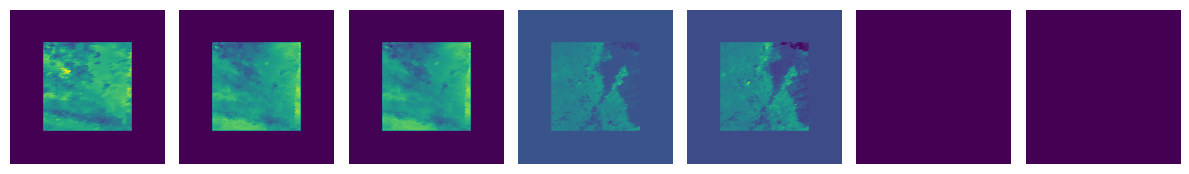

In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,7, figsize=(12, 12))
for i, current_ax in enumerate(ax.flat):
    current_ax.axis('off')
    if i<7:
        current_ax.imshow(np.nan_to_num(x[i,...],0.0))
plt.tight_layout()

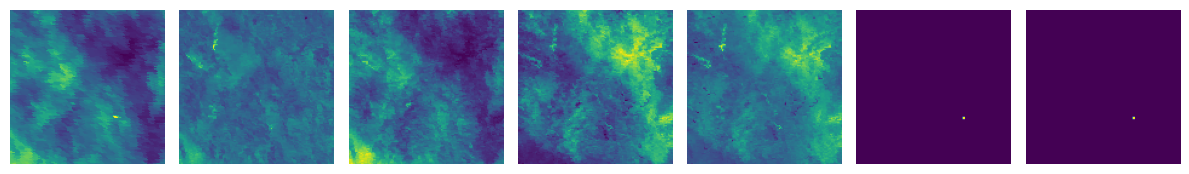

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,7, figsize=(12, 12))
for i, current_ax in enumerate(ax.flat):
    current_ax.axis('off')
    if i<7:
        current_ax.imshow(np.nan_to_num(x[i,...],0.0))
plt.tight_layout()

Now padding

Zero padded images now have shape: torch.Size([7, 224, 224])


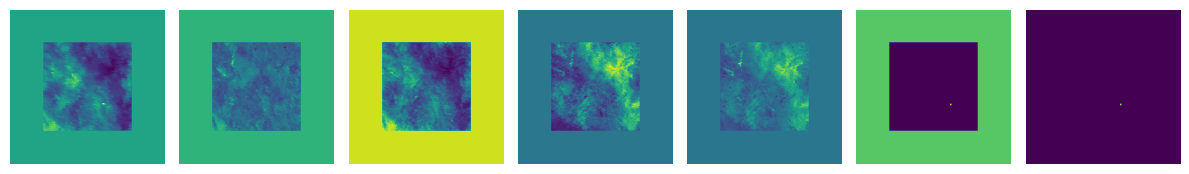

In [14]:
T, H, W = x.shape
crop_side_length = 224
if H < crop_side_length or W < crop_side_length:
    pad_height = max(0, crop_side_length - H)
    pad_width = max(0, crop_side_length - W)

    padding = (pad_width // 2, pad_width - pad_width // 2,  # Left, right
            pad_height // 2, pad_height - pad_height // 2)  # Top, bottom
    
    # Apply padding to both x and y
    x = torch.nn.functional.pad(x, padding)
print(f"Zero padded images now have shape: {x.shape}")

fig, ax = plt.subplots(1,7, figsize=(12, 12))
for i, current_ax in enumerate(ax.flat):
    current_ax.axis('off')
    if i<7:
        current_ax.imshow(np.nan_to_num(x[i,...],0.0))
plt.tight_layout()

In [39]:
import torch
from torch.utils.data import DataLoader
from dataloader.FireSpreadDataset import FireSpreadDataset


data_dir = "/home/sl221120/scratch/WildfireSpreadTS_HDF5"
included_fire_years = [2017, 2018, 2019]
n_leading_observations = 5
crop_side_length = 128
load_from_hdf5 = True
is_train = True
remove_duplicate_features = True
stats_years = (2018, 2019)
n_leading_observations_test_adjustment = 5
features_to_keep = [0, 1, 2, 3, 4, 38, 39]
return_doy = False

dataset = FireSpreadDataset(
    data_dir=data_dir,
    included_fire_years=included_fire_years,
    n_leading_observations=n_leading_observations,
    crop_side_length=crop_side_length,
    load_from_hdf5=load_from_hdf5,
    is_train=is_train,
    remove_duplicate_features=remove_duplicate_features,
    stats_years=stats_years,
    n_leading_observations_test_adjustment=n_leading_observations_test_adjustment,
    features_to_keep=features_to_keep,
    return_doy=return_doy
)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Fetch a batch
for batch in data_loader:
    # Break after getting the first batch
    break

# If you want to inspect specific parts of the batch:
inputs, labels = batch
print("Inputs shape: ", inputs.shape)
print("Labels.shape: ", labels.shape)


Inputs shape:  torch.Size([4, 35, 128, 128])
Labels.shape:  torch.Size([4, 128, 128])


In [40]:
data_dir = '/home/sl221120/scratch/WildfireSpreadTS_HDF5/2018'
print(os.listdir(data_dir))

['fire_21890013.hdf5', 'fire_21889990.hdf5', 'fire_21459239.hdf5', 'fire_21890010.hdf5', 'fire_21690102.hdf5', 'fire_21998230.hdf5', 'fire_21890078.hdf5', 'fire_21999321.hdf5', 'fire_21688916.hdf5', 'fire_21804589.hdf5', 'fire_21748801.hdf5', 'fire_21890100.hdf5', 'fire_21890058.hdf5', 'fire_21890143.hdf5', 'fire_21890111.hdf5', 'fire_21890087.hdf5', 'fire_21889763.hdf5', 'fire_21999260.hdf5', 'fire_21690064.hdf5', 'fire_21890106.hdf5', 'fire_22258318.hdf5', 'fire_22141571.hdf5', 'fire_21890101.hdf5', 'fire_21805022.hdf5', 'fire_21998081.hdf5', 'fire_21751305.hdf5', 'fire_22258087.hdf5', 'fire_21890091.hdf5', 'fire_21889994.hdf5', 'fire_21615465.hdf5', 'fire_21804895.hdf5', 'fire_22141461.hdf5', 'fire_22141528.hdf5', 'fire_21999354.hdf5', 'fire_21997864.hdf5', 'fire_21890643.hdf5', 'fire_22141465.hdf5', 'fire_21889953.hdf5', 'fire_21889682.hdf5', 'fire_21748798.hdf5', 'fire_21999299.hdf5', 'fire_21459242.hdf5', 'fire_21889798.hdf5', 'fire_22141195.hdf5', 'fire_21889995.hdf5', 'fire_214

In [41]:
import h5py
from datetime import datetime
filename = "/home/sl221120/scratch/WildfireSpreadTS_HDF5/2018/fire_21890013.hdf5"

in_fire_index = 0
end_index = 6
with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    imgs = f["data"][in_fire_index:end_index]
    doys = f["data"].attrs["img_dates"][in_fire_index:(
        end_index-1)]
    date_format = "%Y-%m-%d"
        # In old preprocessing, the dates still had a TIF file extension, which is also removed here.
    doys = [datetime.strptime(img_date.replace(".tif", ""), date_format).timetuple().tm_yday for img_date in doys]
    #doys = self.img_dates_to_doys(doys)
    doys = torch.Tensor(doys)
    print(doys)





tensor([201., 202., 203., 204., 205.])


In [42]:
import torch
from dataloader.FireSpreadDataModule import FireSpreadDataModule

# Define the necessary parameters
data_dir = '/home/sl221120/scratch/WildfireSpreadTS_HDF5'
batch_size = 1
n_leading_observations = 5  # For 5 days of observation
n_leading_observations_test_adjustment = 5  # Adjust based on your requirement
crop_side_length = 224  # Example value, adjust as needed
load_from_hdf5 = True  # Adjust based on your data format
num_workers = 4  # Number of workers for data loading
remove_duplicate_features = True  # Adjust based on your data preprocessing

# Initialize the data module with the defined parameters
data_module = FireSpreadDataModule(
    data_dir=data_dir,
    batch_size=batch_size,
    n_leading_observations=n_leading_observations,
    n_leading_observations_test_adjustment=n_leading_observations_test_adjustment,
    crop_side_length=crop_side_length,
    load_from_hdf5=load_from_hdf5,
    num_workers=num_workers,
    remove_duplicate_features=remove_duplicate_features
)

# Setup the data module to prepare the datasets
data_module.setup()

# Get a batch from the training data loader
train_dataloader = data_module.train_dataloader()
data_iter = iter(train_dataloader)
sample_data, _ = next(data_iter)

# Print the shape of the sample data
print(f"Sample data shape: {sample_data.shape}")


Using the following dataset split:
Train years: [2018, 2019], Val years: [2020], Test years: [2021]
Sample data shape: torch.Size([1, 120, 224, 224])


In [8]:
n_features = FireSpreadDataset.get_n_features(n_observations=1, features_to_keep=None,
                                              deduplicate_static_features=True)
n_features

40

In [44]:
# Parameters for get_n_features
n_observations = 5  # For 5 days of observation
features_to_keep = None  # Use None to keep all features or specify a list of feature indices to keep
deduplicate_static_features = True  # Adjust based on your data preprocessing

# Call the get_n_features method
n_features = FireSpreadDataset.get_n_features(n_observations, features_to_keep, deduplicate_static_features)

# Print the number of features from get_n_features
print(f"Number of features from get_n_features: {n_features}")

# Compare the number of channels from sample data shape and get_n_features
sample_n_channels = sample_data.shape[1]
print(f"Number of channels from sample data shape: {sample_n_channels}")

# Compare both values
print(f"Comparison - Sample data channels: {sample_n_channels}, Computed features: {n_features}")


Number of features from get_n_features: 120
Number of channels from sample data shape: 120
Comparison - Sample data channels: 120, Computed features: 120


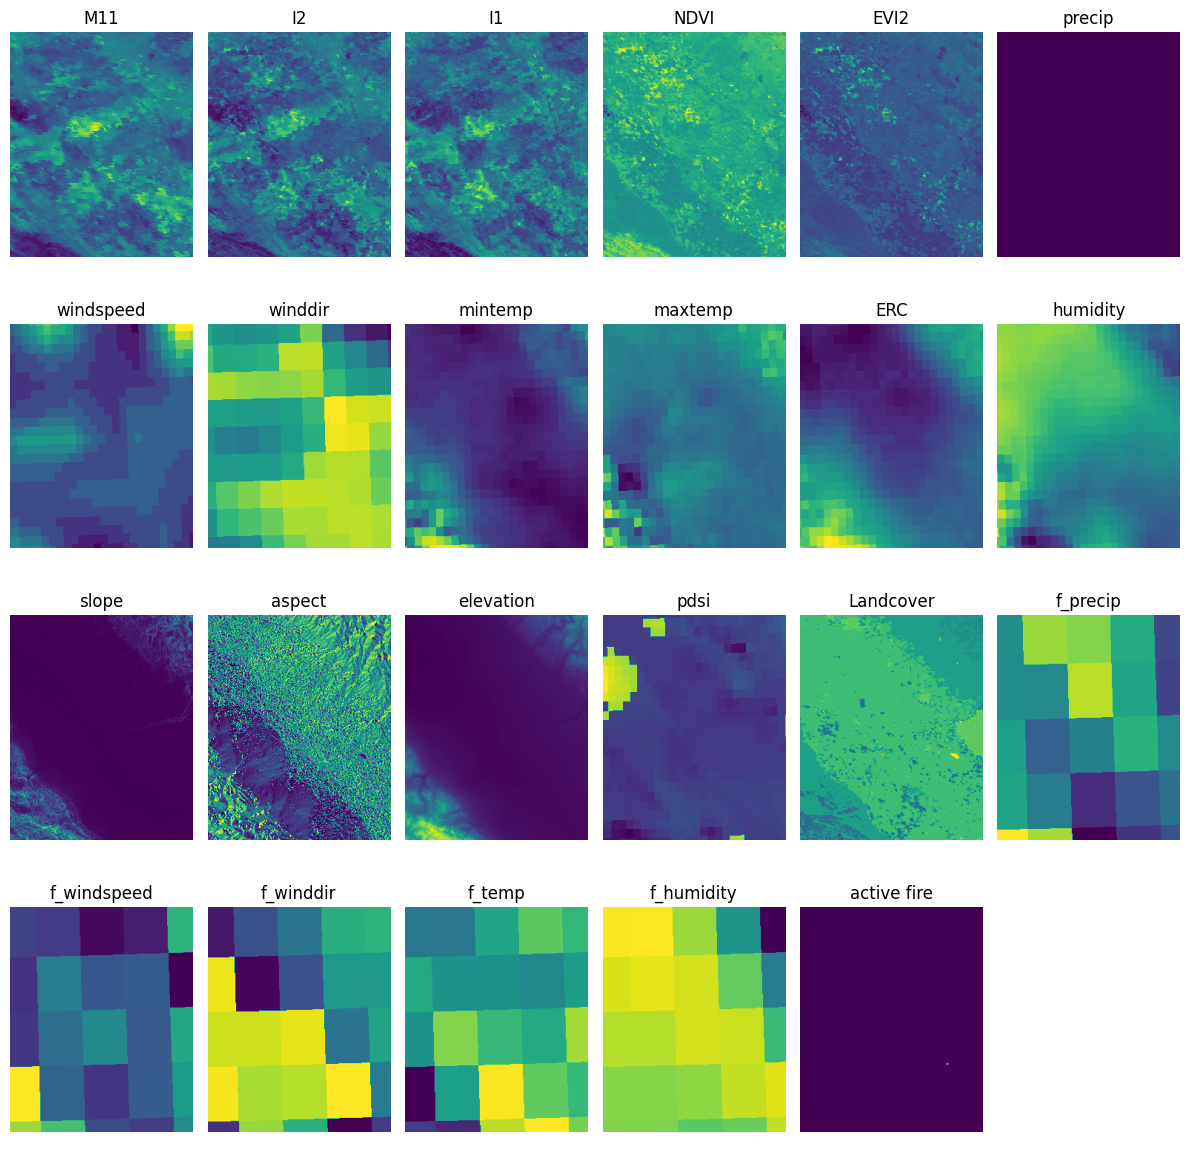

In [45]:
import rasterio
import matplotlib.pyplot as plt   
import numpy as np
import os



img_path = "/home/sl221120/scratch/WildfireSpreadTS/2018/fire_21458798/2018-01-01.tif"
with rasterio.open(img_path, 'r') as f:
    img = f.read()

labels =        {0: 'M11',
                1: 'I2',
                2: 'I1',
                3: 'NDVI',
                4: 'EVI2',
                5: 'precip',
                6: 'windspeed',
                7: 'winddir',
                8: 'mintemp',
                9: 'maxtemp',
                10: 'ERC',
                11: 'humidity',
                12: 'slope',
                13: 'aspect',
                14: 'elevation',
                15: 'pdsi',
                16: 'Landcover',
                17: 'f_precip',
                18: 'f_windspeed',
                19: 'f_winddir',
                20: 'f_temp',
                21: 'f_humidity',
                22: 'active fire'}
fig, ax = plt.subplots(4,6, figsize=(12, 12))
for i, current_ax in enumerate(ax.flat):
    current_ax.axis('off')
    if i<=22:
        current_ax.imshow(np.nan_to_num(img[i,...],0.0))
        current_ax.set_title(labels[i])
plt.tight_layout()
        


Using the following dataset split:
Train years: [2018, 2019], Val years: [2020], Test years: [2021]
Processing batch 1 with shape torch.Size([1, 120, 224, 224])
Processing batch 2 with shape torch.Size([1, 120, 224, 224])
Processing batch 3 with shape torch.Size([1, 120, 224, 224])
Processing batch 4 with shape torch.Size([1, 120, 224, 224])
Processing batch 5 with shape torch.Size([1, 120, 224, 224])
Processing batch 6 with shape torch.Size([1, 120, 224, 224])
Error encountered during iteration: Caught ValueError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "/home/sl221120/anaconda3/envs/fire_ts/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/sl221120/anaconda3/envs/fire_ts/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/sl221120/anaconda3/envs/fire

In [19]:
import torch

predictions_file_name="/home/sl636/WildfireSpreadTS/lightning_logs/predictions_gcmiitbv.pt"

fire_masks_combined = torch.load(predictions_file_name)



FileNotFoundError: [Errno 2] No such file or directory: '/home/sl636/WildfireSpreadTS/lightning_logs/predictions_gcmiitbv.pt'

In [20]:
# Extract the input fire masks, predicted fire masks, and ground truth fire masks
x_af = fire_masks_combined[0]
y_hat = fire_masks_combined[1]
y = fire_masks_combined[2]

NameError: name 'fire_masks_combined' is not defined

In [22]:
from torchmetrics import AveragePrecision

# Initialize the AveragePrecision metric
ap_metric = AveragePrecision(task="binary")

# Update the metric with each sample
num_samples = y_hat.shape[0]
for j in range(num_samples):
    ap_metric.update(y_hat[j].flatten(), y[j].flatten().int())

# Compute the overall average precision
overall_ap_value = ap_metric.compute()
print(f'Overall Average Precision: {overall_ap_value:.4f}')

NameError: name 'y_hat' is not defined

In [23]:
import torch
from torchmetrics import AveragePrecision
import matplotlib.pyplot as plt

# Assume fire_masks_combined is a tensor containing the input, predicted, and ground truth fire masks
# fire_masks_combined.shape should be (3, num_samples, height, width)

# Extract the input fire masks, predicted fire masks, and ground truth fire masks
x_af = fire_masks_combined[0]
y_hat = fire_masks_combined[1]
y = fire_masks_combined[2]

# Initialize a list to store AP values
ap_values = []

# Compute the AP for each sample and store the values
num_samples = y_hat.shape[0]
for j in range(num_samples):
    ap_metric = AveragePrecision(task="binary")
    ap_metric.update(y_hat[j].flatten(), y[j].flatten().int())
    ap_value = ap_metric.compute()
    ap_values.append(ap_value.item())

# Plot a histogram of AP values
plt.hist(ap_values, bins=20, edgecolor='black')
plt.xlabel('Average Precision')
plt.ylabel('Frequency')
plt.title('Histogram of Average Precision for all 2021 Test Samples')
plt.show()


NameError: name 'fire_masks_combined' is not defined

In [24]:
# Plot a histogram of AP values
plt.hist(ap_values, bins=20, edgecolor='black')
plt.xlabel('Average Precision')
plt.ylabel('Frequency')
plt.title('Histogram of Average Precision for all 2021 Test Samples')
plt.show()

NameError: name 'ap_values' is not defined

In [25]:
import random 
lt_10pc = []
for i in range(x_af.shape[0]):
    if x_af[i].sum() < 1638:
        lt_10pc.append(i)

len(lt_10pc)

plot_lt_10pc = random.sample(lt_10pc, 10)
plot_lt_10pc



NameError: name 'x_af' is not defined

In [26]:
import matplotlib.pyplot as plt
import torch
from torchmetrics import AveragePrecision

# Assume x_af, y, and y_hat are already defined as torch tensors

def apply_threshold(tensor, threshold=0.5):
    """Apply a threshold to convert the tensor to binary values."""
    return (tensor > threshold).float()

# Plotting
fig, axes = plt.subplots(len(plot_lt_10pc), 3, figsize=(15, 5 * len(plot_lt_10pc)))

for i, j in enumerate(plot_lt_10pc):
    axes[i, 0].imshow(x_af[j].cpu().numpy(), cmap="viridis")
    axes[i, 0].set_title("Active fire")
    axes[i, 1].imshow(y[j].cpu().numpy(), cmap="viridis")
    axes[i, 1].set_title("Next fire")
    
    # Apply threshold to the predicted output for binary visualization
    binary_y_hat = apply_threshold(y_hat[j])
    axes[i, 2].imshow(y_hat[j], cmap="viridis")
    
    # Compute the average precision for the current sample
    ap_metric = AveragePrecision(task="binary")
    ap_metric.update(y_hat[j].flatten(), y[j].flatten().int())
    ap_value = ap_metric.compute()
    
    # Set the title with the average precision value
    axes[i, 2].set_title(f"Predicted fire (AP: {ap_value:.2f})")


plt.tight_layout()
plt.show()


NameError: name 'plot_lt_10pc' is not defined

In [27]:
non_empty = []
for i in range(x_af.shape[0]):
    if x_af[i].sum() > 3000:
        non_empty.append(i)

non_empty

NameError: name 'x_af' is not defined

In [28]:
import matplotlib.pyplot as plt
import torch
from torchmetrics import AveragePrecision

# Assume x_af, y, and y_hat are already defined as torch tensors

def apply_threshold(tensor, threshold=0.5):
    """Apply a threshold to convert the tensor to binary values."""
    return (tensor > threshold).float()

# Plotting
fig, axes = plt.subplots(len(non_empty), 3, figsize=(15, 5 * len(non_empty)))

for i, j in enumerate(non_empty):
    axes[i, 0].imshow(x_af[j].cpu().numpy(), cmap="viridis")
    axes[i, 0].set_title("Active fire")
    axes[i, 1].imshow(y[j].cpu().numpy(), cmap="viridis")
    axes[i, 1].set_title("Next fire")
    
    # Apply threshold to the predicted output for binary visualization
    binary_y_hat = apply_threshold(y_hat[j])
    axes[i, 2].imshow(y_hat[j], cmap="viridis")
    
    # Compute the average precision for the current sample
    ap_metric = AveragePrecision(task="binary")
    ap_metric.update(y_hat[j].flatten(), y[j].flatten().int())
    ap_value = ap_metric.compute()
    
    # Set the title with the average precision value
    axes[i, 2].set_title(f"Predicted fire (AP: {ap_value:.2f})")


plt.tight_layout()
plt.show()


ValueError: Number of rows must be a positive integer, not 0

<Figure size 1500x0 with 0 Axes>

FileNotFoundError: [Errno 2] No such file or directory: '/home/sl636/TS_data/2018/fire_21458798'

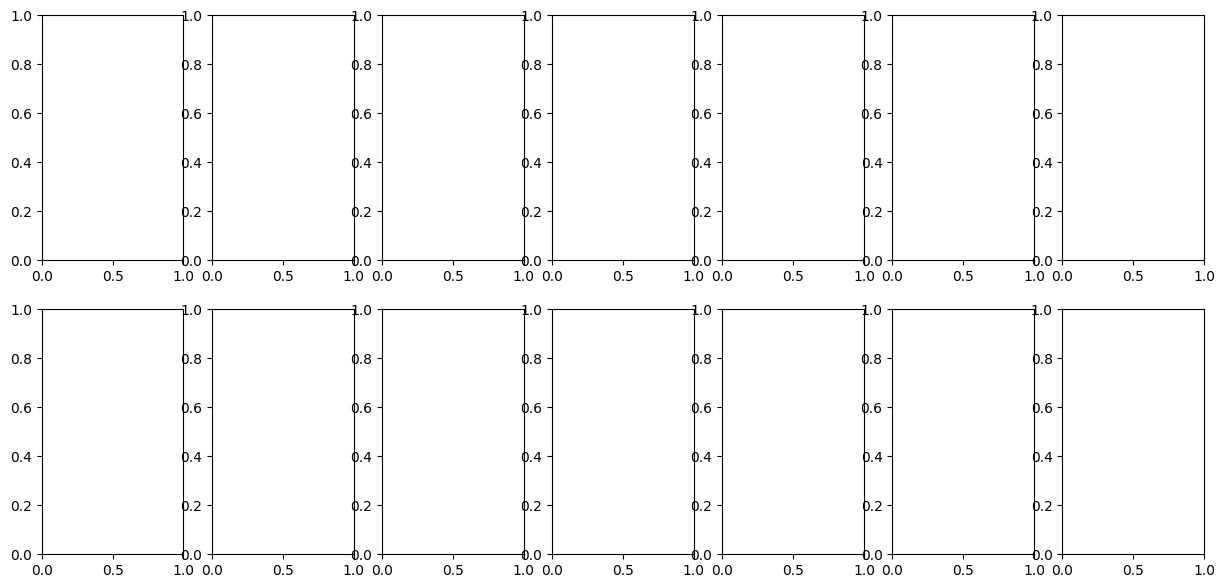

In [30]:
fire_path = "/home/sl636/TS_data/2018/fire_21458798"
fig, ax = plt.subplots(2,7, figsize=(15, 7))

for i, image in enumerate(sorted(os.listdir(fire_path))):
    img_path = os.path.join(fire_path, image)
    with rasterio.open(img_path, 'r') as f:
        img = f.read()
    current_ax = ax.flat[i]
    current_ax.axis('off')
    current_ax.imshow(np.nan_to_num(img[22,...],0.0))
    current_ax.set_title(image.split(".")[0])
plt.tight_layout()
        


In [4]:
def plot_fire(fire_path):
    fire_images = sorted(os.listdir(fire_path))
    num_fires = len(fire_images)
    
    num_cols = min(num_fires, 7)  # Limit columns to a maximum of 7 for better visualization
    num_rows = (num_fires + num_cols - 1) // num_cols  # Calculate the number of rows needed
    fig_width = 2 * num_cols
    fig_height = 2 * num_rows
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

    
    # Flatten the axes array for easy iteration
    if num_rows == 1:
        ax = [ax]
    else:
        ax = ax.flatten()

    for i, image in enumerate(sorted(os.listdir(fire_path))):
        img_path = os.path.join(fire_path, image)
        with rasterio.open(img_path, 'r') as f:
            img = f.read()
        current_ax = ax.flat[i]
        current_ax.axis('off')
        current_ax.imshow(np.nan_to_num(img[22,...],0.0))
        current_ax.set_title(image.split(".")[0], fontsize=10)
    
    
    for j in range(num_fires, len(ax)):
        ax[j].axis('off')
    plt.tight_layout()

    
        


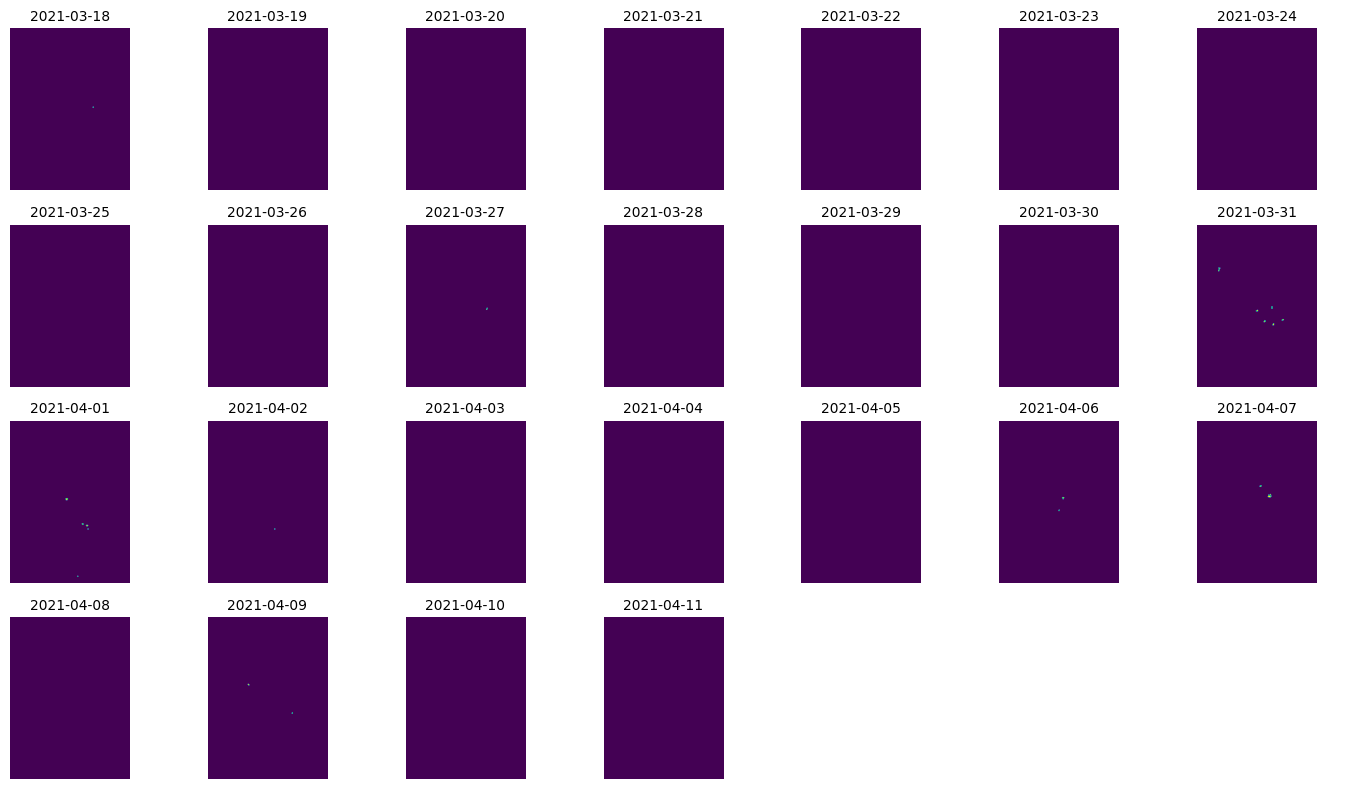

In [5]:
#fire_path = "/home/sl636/TS_data/2021/fire_24935874"
fire_path = "/home/sl636/TS_data/2021/fire_25017323"
plot_fire(fire_path)